# Bake / Freeze Temperature Time Series 
I took my SixTemp rig and put it in the oven, then took it out and let it cool to room temperature, then put it in a freezer, then took it out and let it come to room temperature. The whole process took over an hour and resulted in a huge file on the SD, 37 MB! It quit before I stopped it, possibly something to do with the file size, but I don't know. As a result, some of the calculations may take a very long time.

**Safety Note:** If you want to try this, be sure to keep the battery cool, as Li-Ion batteries can explode at high temperatures.

## Read in Data from a CSV file

Used the Read a CSV example as a starter file. You may want to go back to it for later parts of this exercise.

In [11]:
# gets all of numpy but you will still need to refer to e.g. numpy.random.randn() as random.randn()
from numpy import *               # all of the array capable elements for numerical data          
from scipy.stats import norm      # comprehensive functions for Gaussian normal distributions
import csv                        # library for reading and writing comma separated value files
from matplotlib.pyplot import *   # all of pyplot to graph the results of our calculations

# put figures inline in the notebook, so you don't have to call show()
%matplotlib inline

# http://blog.rtwilson.com/how-to-get-nice-vector-graphics-in-your-exported-pdf-ipython-notebooks/
# needs to come after the %matplotlib inline in order to produce high grade LaTeX output
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# This lets you make the default figure size larger (or smaller)
from IPython.core.pylabtools import figsize
figsize(14, 7)

with open('6TMP0019BakeFreeze.CSV') as csvfile:
    dataRead = csv.reader(csvfile)
    a = np.asarray([data for data in dataRead])
print(a[0:5])


[['seconds' ' T0' ' T1' ' T2' ' T3' ' T4' ' T5' ' ']
 ['5.106' ' 23.581' ' 25.571' ' 25.173' ' 25.093' ' 25.013' ' 25.093' ' ']
 ['5.248' ' 23.979' ' 25.571' ' 25.013' ' 25.093' ' 25.093' ' 24.695' ' ']
 ['5.258' ' 23.899' ' 25.650' ' 25.173' ' 25.491' ' 25.252' ' 25.013' ' ']
 ['5.265' ' 23.820' ' 25.491' ' 25.093' ' 25.332' ' 25.332' ' 24.854' ' ']]


In [12]:
print(np.shape(a))
t = np.asfarray(a[1:,0]) 
labs = a[0,1:]
d = np.asfarray(a[1:,1:len(a[1])-1])
print(labs)
print(d[0:5])

(634640, 8)
[' T0' ' T1' ' T2' ' T3' ' T4' ' T5' ' ']
[[ 23.581  25.571  25.173  25.093  25.013  25.093]
 [ 23.979  25.571  25.013  25.093  25.093  24.695]
 [ 23.899  25.65   25.173  25.491  25.252  25.013]
 [ 23.82   25.491  25.093  25.332  25.332  24.854]
 [ 23.74   25.491  25.252  25.093  25.173  25.173]]


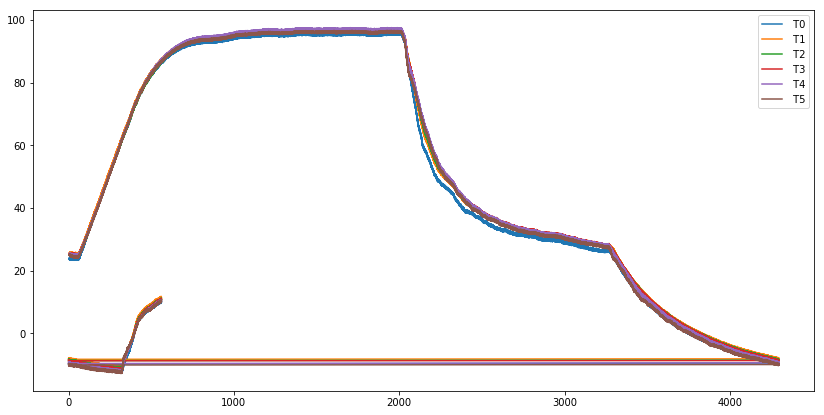

In [13]:
for i in range(0,6):
    plot(t,d[:,i],label=labs[i])
legend()

This little test went on so long the time count rolled over back to zero and started again. The biggest number you can represent in a 32 bit unsigned is 2^32 - 1 or 0xFFFFFFFF in hexadecimal. It's about 4 billion, so if it is microseconds you're counting it will be about 4000 seconds before the time rolls over back to zero. This little code fragment fixes the time track.

In [14]:
i = 0
while(t[i] < 3000):      # skip the beginning
    i += 1
while(i < len(t)):
    if(t[i] < 2000):     # add the right number of seconds to the small values of t
        t[i] += 0xFFFFFFFF/1000000.
    i += 1

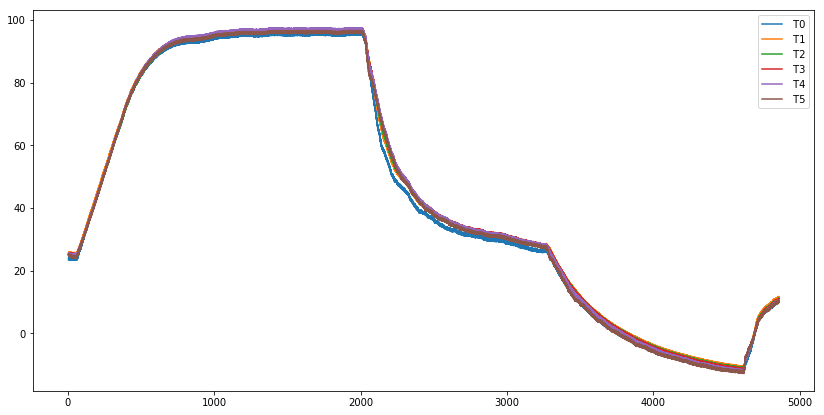

In [15]:
for i in range(0,6):
    plot(t,d[:,i],label=labs[i])
legend()

In [16]:
means = np.zeros(6)
stds = means.copy()
for i in range(0,6): 
    means[i] = np.mean(d[:,i])
    stds[i] = np.std(d[:,i],ddof=1)
print(means)
print(stds)

[ 44.43260258  46.10474171  45.79337266  46.02681507  45.91446706
  45.19054868]
[ 39.6362621   39.53050428  39.5094506   39.75793321  40.03454669
  39.94456695]


None of those mean or SD values really describes the time series well, because it isn't nearly constant with time. A moving average of some kind will work way better, although the calculation process may get time consuming for such a big chunk of data!

(90, 100)

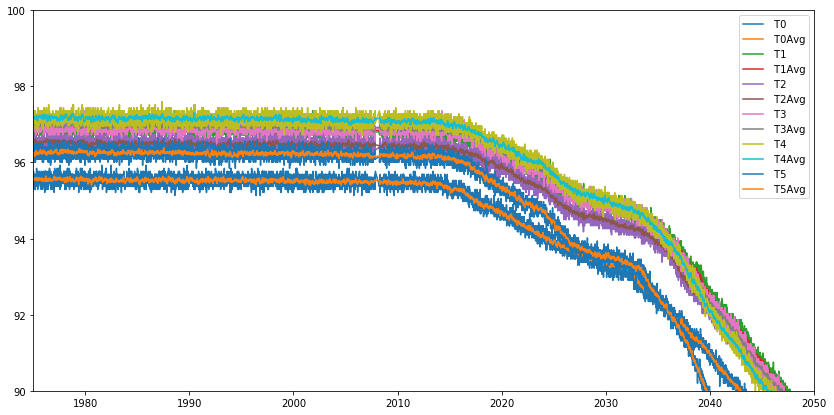

In [17]:
n = 5
Tma = d.copy()
# We can only do a moving average when there are enough values before and after
for i in range(n,len(t)-n): 
    for j in range(0,6):
        Tma[i,j] = np.mean(d[i-n:i+n+1,j])
for i in range(0,6):
    plot(t,d[:,i],label=labs[i])
    plot(t[n:len(t)-n],Tma[n:len(t)-n,i],label=labs[i]+'Avg')
legend()
xlim(1975,2050)
ylim(90,100)

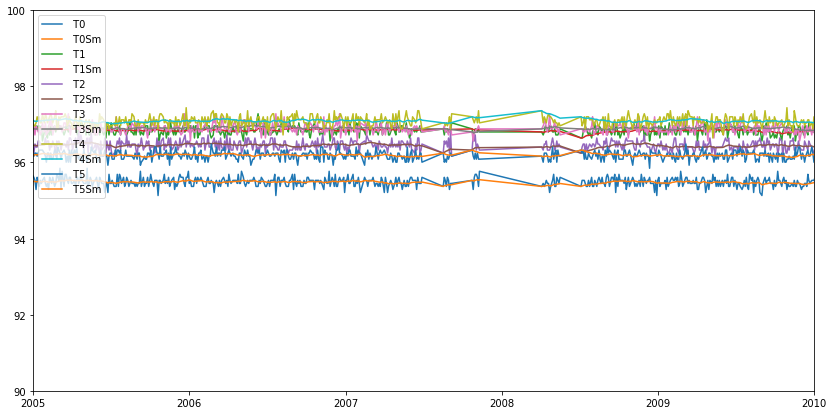

In [18]:
Tau = 0.1
Tsm = d.copy()
# We can only do smoothing for the second and later values in the series
for i in range(1,len(t)):
    w = min((t[i]-t[i-1])/Tau,1)
    for j in range(0,6):
        Tsm[i,j] = w * d[i,j] + (1-w) * Tsm[i-1,j]
for i in range(0,6):
    plot(t[250000:300000],d[250000:300000,i],label=labs[i])
    plot(t[250000:300000],Tsm[250000:300000,i],label=labs[i]+'Sm')
xlim(1975,2050)
xlim(2005,2010)
ylim(90,100)
legend(loc=2)


Something funny is happening around 2007 seconds -- zoom in and take a look. It looks like there are some gaps in the file where no data was taken for about half a second. Was it because it was too hot? (The whole package was operating near 100C) Are there similar dropouts elsewhere?

In [19]:
for i in range(1,len(t)):
    if((t[i]-t[i-1]) > 0.25):
        print(i,t[i],t[i-1])

7803 65.537 65.159
12894 105.578 105.322
52831 410.097 409.724
61752 478.33 477.827
85685 662.467 662.201
93626 722.781 722.396
121300 935.09 934.709
221920 1705.626 1705.369
229942 1767.908 1767.517
237784 1828.008 1827.623
245623 1888.074 1887.808
253460 1948.107 1947.72
261310 2008.255 2007.857
269161 2068.45 2068.054
277022 2128.503 2128.24
294377 2260.648 2260.263
302228 2320.801 2320.416
310082 2380.867 2380.616
317939 2441.003 2440.749
325797 2501.007 2500.739
333664 2561.157 2560.884
341524 2621.289 2621.023
345765 2653.669 2653.298
345893 2655.231 2654.973
353970 2717.757 2717.499
361816 2777.829 2777.452
369660 2837.963 2837.683
377517 2897.912 2897.652
412188 3162.473 3162.096
459410 3522.937 3522.554
478419 3665.574 3665.321
542899 4155.723 4155.352
571294 4371.951295 4371.568295
618273 4732.320295 4732.058295
618396 4734.397295 4734.130295
627168 4800.388295 4800.001295
